<a href="https://colab.research.google.com/github/YuhaoAlex/User-Churn-Preidction/blob/master/User_Chrun_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Churn Prediction
#### Data from a telecommnication company
#### Goals:
#### Build a supervised learning model based on data
#### Predict customers who are likely to stop service
#### Find possible factors that may influence customers' decision


##1.Set up environment and prepare data

In [0]:
#setup envrionment, get authentication
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth) 

In [0]:
#acquire file link
link = 'https://drive.google.com/open?id=1a0HVm1Qk6xxWG9SxkkQDmyXjIeCZr_gR'
fluff, id = link.split('=')
print(id)

1a0HVm1Qk6xxWG9SxkkQDmyXjIeCZr_gR


In [0]:
#Read from link(id)
file = drive.CreateFile({'id':id})
file.GetContentFile('churn.csv')

In [0]:
#Transform to Pandas DataFram
import pandas as pd

df = pd.read_csv('churn.csv')
df.head(10)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


##1.1 Data preprocess

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

In [0]:
#remove whitespaces and useless '.'
df['phone_number'] = df['phone_number'].apply(lambda x: x.strip())
df['voice_mail_plan'] = df['voice_mail_plan'].apply(lambda x: x.strip())
df['intl_plan'] = df['intl_plan'].apply(lambda x: x.strip())
df['churned'] = df['churned'].apply(lambda x: x.strip())\
                              .apply(lambda x: x.strip('.'))
df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']

#convert string 'yes' 'no' to bool
yes_no_cols = ['intl_plan','voice_mail_plan']
df[yes_no_cols] = df[yes_no_cols] == 'yes'
df['churned'] = df['churned'] == 'True'
                             
#convert number from string to int
def convert_int(x):
  x = x.replace('-','')
  return int(x)

df['phone_number'] = df['phone_number'].apply(lambda x: convert_int(x))

##1.2 Feature distribution

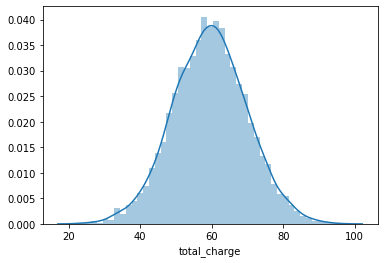

In [0]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(df['total_charge'])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null int64
intl_plan                        5000 non-null bool
voice_mail_plan                  5000 non-null bool
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes               5

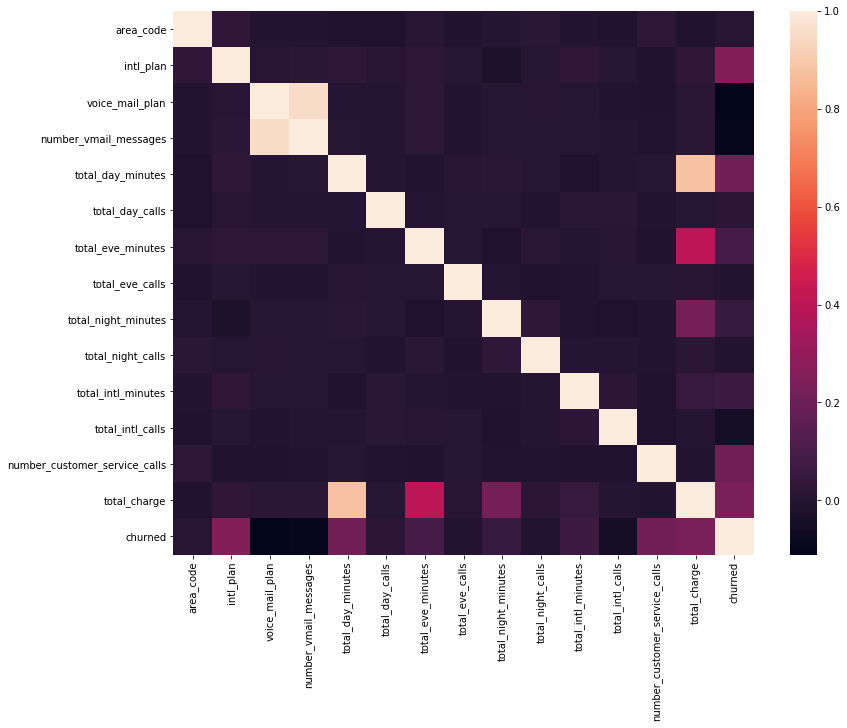

In [0]:
#correlation between features
cl = df[['area_code','intl_plan','voice_mail_plan','number_vmail_messages','total_day_minutes','total_day_calls',
         'total_eve_minutes','total_eve_calls','total_night_minutes','total_night_calls','total_intl_minutes','total_intl_calls',
         'number_customer_service_calls','total_charge','churned']].corr()
fig, axes = plt.subplots(1,1,figsize=(13,10))
sb.heatmap(cl)

In [0]:
from scipy.stats import pearsonr

print(pearsonr(df['churned'],df['total_charge']))
print(pearsonr(df['churned'],df['number_customer_service_calls']))

(0.23547248602021367, 5.8800446725827684e-64)
(0.2125640465594386, 3.492304108644311e-52)


##2. Feature Selection

In [0]:
df.head(200)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned,total_charge
0,KS,128,415,3824657,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,415,3717191,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,415,3581921,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,408,3759999,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,415,3306626,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,MD,117,415,3857688,False,True,23,198.1,86,33.68,177.0,86,15.05,180.5,92,8.12,6.8,6,1.84,1,False,58.69
196,TN,78,415,3326934,False,False,0,149.7,119,25.45,182.2,115,15.49,261.5,126,11.77,9.7,8,2.62,0,False,55.33
197,TX,208,510,3783625,False,False,0,326.5,67,55.51,176.3,113,14.99,181.7,102,8.18,10.7,6,2.89,2,True,81.57
198,ME,131,510,3537292,True,True,26,292.9,101,49.79,199.7,97,16.97,255.3,127,11.49,13.8,7,3.73,4,True,81.98


In [0]:
#get ground truth data
y = np.where(df['churned']==True, 1,0)

#drop useless columns
X = df.drop(['state','area_code','phone_number','churned'],axis=1) #drop 'churned' because it is the label



In [0]:
X

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,total_charge
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,50,False,True,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,75.09
4996,152,False,False,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3,66.72
4997,61,False,False,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1,51.82
4998,109,False,False,0,188.8,67,32.10,171.7,92,14.59,224.4,89,10.10,8.5,6,2.30,0,59.09


## 3. Model Training and Result Evaluation

In [0]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

#split data into training data and testing data
#80% for training, 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

print('Train data size is: '+ str(X_train.shape[0]))
print('Test data size is:' + str(X_test.shape[0]))

#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Train data size is: 4000
Test data size is:1000


####3.2 Model Training

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Build instances
logistic_model = LogisticRegression(C=7)
KNN_model = KNeighborsClassifier()
RF_model = RandomForestClassifier()
SVC_model = SVC()

In [0]:
#LOgisticRegression
logistic_model.fit(X = X_train, y=y_train)

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
logistic_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
logistic_model.score(X_test, y_test)

0.876

In [0]:
#use KNN model to predict
KNN_model.fit(X_train, y_train)
KNN_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

In [0]:
KNN_model.score(X_test,y_test)

0.906

In [0]:
#Predict with Random Forest model
RF_model.fit(X_train, y_train)
RF_model.predict(X_test)
RF_model.score(X_test, y_test)

0.985

In [0]:
#Use 5-fold Cross Validation to get the accuracy for the 3 different models
modelNames = ['Logistic Regression', 'KNN', 'Random Forest', 'SVM']
modelList = [logistic_model, KNN_model, RF_model, SVC_model]
count = 0

for classifier in modelList:
  score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
  print(score)
  print('Score for model' + modelNames[count] + ' is '+ str(round(score.mean(),4)))
  count+=1

[0.8475  0.84875 0.8675  0.86125 0.87   ]
Score for modelLogistic Regression is 0.859
[0.915   0.8975  0.8975  0.905   0.90125]
Score for modelKNN is 0.9033
[0.98    0.97625 0.96625 0.97625 0.98   ]
Score for modelRandom Forest is 0.9758
[0.92875 0.93125 0.93125 0.92625 0.92   ]
Score for modelSVM is 0.9275


###3.3 Find Optimal Hyperparameters with Grid Search

####Logistic Regression

In [0]:
from sklearn.model_selection import GridSearchCV

#L1 or L2 as penalty
# 'c' is the lambda value(weight) for L1 and L2

parameters = {'penalty': ('l1','l2'),
                'C': (1,5,10)}
Grid_LR = GridSearchCV(LogisticRegression(), parameters, cv=5)
Grid_LR.fit(X_train, y_train)

              

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
#helper function for printing out grid seach results
def print_metrics(gs):
  print("Best Score: "+ str(gs.best_score_))
  print("Best Parameter is: " )
  best_parameters = gs.best_params_
  for name in sorted(parameters.keys()):
    print(name + ':' + str(best_parameters[name]))

print_metrics(Grid_LR)

Best Score: 0.85925
Best Parameter is: 
C:1
penalty:l2


In [0]:
#So the best model is
bestLR = Grid_LR.best_estimator_

####KNN

In [0]:
#Find the proper K

parameters = { 'n_neighbors':[3,4,5,6,7,8,9,10]}
Grid_KNN = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
#Find the best K
print_metrics(Grid_KNN)


Best Score: 0.9032500000000001
Best Parameter is: 
n_neighbors:5


In [0]:
bestKNN = Grid_KNN.best_estimator_

#### Random Forest


In [0]:
#Find the proper number of trees
parameters = { 'n_estimators':[40,60,80,100,200,300,400] }

Grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
print_metrics(Grid_RF)

Best Score: 0.9762500000000001
Best Parameter is: 
n_estimators:80


In [0]:
bestRF = Grid_RF.best_estimator_

###3.4 Model Evaluation: Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#calculate accuracy, precision and recall
def evaluate(classifier, cm):
  tn=cm[0][0]
  fp=cm[0][1]
  fn=cm[1][0]
  tp=cm[1][1]
  accuracy = (tp+tn)/(tp + tn + fp + fn + 0.0)
  precision = tp/(tp+fp+0.0)
  recall = tp/(tp+fn+0.0)
  print(classifier)
  print('Accuracy is: ' + str(accuracy))
  print('Precision is: ' + str(precision))
  print('Recall is: ' + str(recall))

def draw_matrices(matrices):
  class_names=['Not','Churn']
  for cm in matrices:
    classifier, cm = cm[0], cm[1]
    evaluate(classifier, cm)

    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, interpolation='nearest', cmap=plt.get_cmap('Reds'))
    plt.title('Confusion matrix for '+ classifier)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+class_names)
    ax.set_yticklabels(['']+class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


Logistic Regression
Accuracy is: 0.876
Precision is: 0.6382978723404256
Recall is: 0.21897810218978103


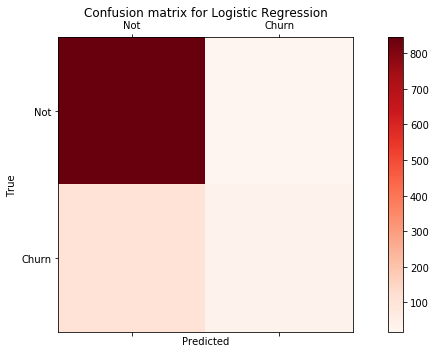

Random Forest
Accuracy is: 0.985
Precision is: 1.0
Recall is: 0.8905109489051095


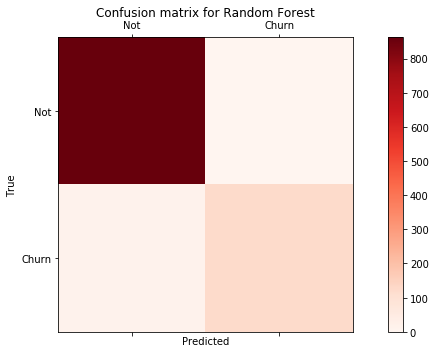

In [0]:
confusion_matrices = [ ("Logistic Regression", confusion_matrix(y_test, bestLR.predict(X_test))),
                      ("Random Forest", confusion_matrix(y_test, bestRF.predict(X_test)))]

draw_matrices(confusion_matrices)

###3.4 Model Evaluation by ROC and AUC

####3.4.1 ROC and AUC of Logistic Regression

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

#use bestLR model to predict
LR_pred = bestLR.predict_proba(X_test)[:,1]

#get the FalsePositive Rate and True Positive Rate using roc_curve function
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, LR_pred)

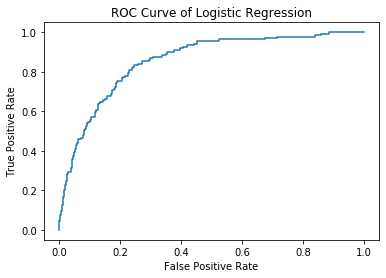

In [0]:
#plot ROC curve
fig, axex = plt.subplots(1,1)
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

In [0]:
#Calculate AUC
metrics.auc(fpr_lr, tpr_lr)

0.8560106909355414

####3.4.2 ROC and AUC of Random Forest Model

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

#Use predict_proba to get the probability results of Random Forest
y_pred = bestRF.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred)

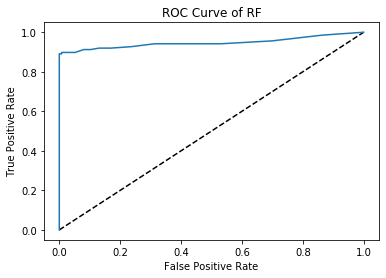

In [0]:
#plot the ROC curve
fig, axes = plt.subplots(1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of RF')
plt.show()

In [0]:
from sklearn import metrics

metrics.auc(fpr_rf, tpr_rf)

0.9472431088293256

##4. Feature Selection

###4.1 Logistic Regression Model

We are interested in the correlated feature pairs:

(total_day_minutes, total_day_charge)

(total_eve_minutes, total_eve_charge)

(total_intl_minutes, total_intl_chage)

In [0]:
#add L1 regularization to logistic regression
#check the coefficient for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X)
LRmodel_l1 = LogisticRegression(penalty='l1',solver='liblinear', C=0.1)
LRmodel_l1.fit(X_l1, y)
LRmodel_l1.coef_[0]
print('Logistic Regression L1 Coefficients')
for k,v in sorted(zip(map(lambda x: round(x,4), LRmodel_l1.coef_[0]), X.columns), key=lambda k_v: (-abs(k_v[0]), k_v[1])):
  print( v+': '+str(k))

Logistic Regression L1 Coefficients
total_charge: 0.7959
number_customer_service_calls: 0.6401
intl_plan: 0.588
voice_mail_plan: -0.4346
total_intl_calls: -0.1474
total_intl_charge: 0.1174
total_intl_minutes: 0.0401
account_length: 0.0353
total_day_calls: 0.0301
total_night_calls: -0.0112
total_eve_calls: -0.0092
number_vmail_messages: 0.0
total_day_charge: 0.0
total_day_minutes: 0.0
total_eve_charge: 0.0
total_eve_minutes: 0.0
total_night_charge: 0.0
total_night_minutes: 0.0


In [0]:
#add L2 regularization to logistic regression
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X)
LRmodel_l2 = LogisticRegression(penalty='l2',solver='lbfgs', C=0.1)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]
print('Logistic Regression L2 Coefficients')
for k,v in sorted(zip(map(lambda x: round(x,4), LRmodel_l2.coef_[0]), X.columns), key=lambda k_v: (-abs(k_v[0]), k_v[1])):
  print( v+': '+str(k))

Logistic Regression L2 Coefficients
number_customer_service_calls: 0.661
voice_mail_plan: -0.6202
intl_plan: 0.6043
total_charge: 0.2832
total_day_minutes: 0.2389
total_day_charge: 0.2383
total_intl_calls: -0.1716
number_vmail_messages: 0.1659
total_eve_charge: 0.1186
total_eve_minutes: 0.1184
total_intl_charge: 0.1104
total_intl_minutes: 0.11
total_night_minutes: 0.069
total_night_charge: 0.0685
account_length: 0.0548
total_day_calls: 0.0502
total_night_calls: -0.0313
total_eve_calls: -0.0297
